## xbgoost
- 커널: [Xtreme Boost and feature engineering](https://www.kaggle.com/krishonaveen/xtreme-boost-and-feature-engineering)
- 모델링보다는 전처리가 중요해 보임. lightGBM으로도 해 보기

In [1]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk("../input"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../input\df_id.pkl
../input\df_pca.pkl
../input\df_test.pkl
../input\df_train.pkl
../input\df_trans.pkl
../input\sample_submission.csv
../input\test.pkl
../input\test_0823.pkl
../input\test_identity.csv
../input\test_transaction.csv
../input\train_0823.pkl
../input\train_identity.csv
../input\train_transaction.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
%matplotlib inline

In [3]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(
        end_mem, 100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
import gc

In [5]:
train = pd.read_pickle("../input/df_train.pkl")
test = pd.read_pickle("../input/df_test.pkl")
sample_submission = pd.read_csv("../input/sample_submission.csv",
                               index_col = "TransactionID")
# df_test = df_test.merge(sample_submission, how='left', left_index=True,
#                          right_index=True, on='TransactionID')

In [7]:
print(train.shape) #왜 커널보다 컬럼이 한개씩 많지?
print(test.shape)

(590540, 434)
(506691, 433)


In [9]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [10]:
cols_to_drop=['V300','V309','V111','C3','V124','V106','V125','V315','V134','V102','V123','V316','V113',
              'V136','V305','V110','V299','V289','V286','V318','V103','V304','V116','V29','V284','V293',
              'V137','V295','V301','V104','V311','V115','V109','V119','V321','V114','V133','V122','V319',
              'V105','V112','V118','V117','V121','V108','V135','V320','V303','V297','V120']

print("{} features are going to be dropped for being useless".format(
len(cols_to_drop)))

train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

50 features are going to be dropped for being useless


In [11]:
len(train.columns)

384

In [12]:
def ploting_cnt_amt(df, col, lim=2000):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    
    plt.figure(figsize=(16,14))    
    plt.suptitle(f'{col} Distributions ', fontsize=24)
    
    plt.subplot(211)
    g = sns.countplot( x=col,  data=df, order=list(tmp[col].values))
    gt = g.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, order=list(tmp[col].values),
                       color='black', legend=False, )
    gt.set_ylim(0,tmp['Fraud'].max()*1.1)
    gt.set_ylabel("%Fraud Transactions", fontsize=16)
    g.set_title(f"Most Frequent {col} values and % Fraud Transactions", fontsize=20)
    g.set_xlabel(f"{col} Category Names", fontsize=16)
    g.set_ylabel("Count", fontsize=17)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    sizes = []
    for p in g.patches:
        height = p.get_height()
        sizes.append(height)
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=12) 
        
    g.set_ylim(0,max(sizes)*1.15)
    
    #########################################################################
    perc_amt = (df.groupby(['isFraud',col])['TransactionAmt'].sum() \
                / df.groupby([col])['TransactionAmt'].sum() * 100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    amt = df.groupby([col])['TransactionAmt'].sum().reset_index()
    perc_amt = perc_amt.fillna(0)
    plt.subplot(212)
    g1 = sns.barplot(x=col, y='TransactionAmt', 
                       data=amt, 
                       order=list(tmp[col].values))
    g1t = g1.twinx()
    g1t = sns.pointplot(x=col, y='Fraud', data=perc_amt, 
                        order=list(tmp[col].values),
                       color='black', legend=False, )
    g1t.set_ylim(0,perc_amt['Fraud'].max()*1.1)
    g1t.set_ylabel("%Fraud Total Amount", fontsize=16)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    g1.set_title(f"{col} by Transactions Total + %of total and %Fraud Transactions", fontsize=20)
    g1.set_xlabel(f"{col} Category Names", fontsize=16)
    g1.set_ylabel("Transaction Total Amount(U$)", fontsize=16)
    g1.set_xticklabels(g.get_xticklabels(),rotation=45)    
    
    for p in g1.patches:
        height = p.get_height()
        g1.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total_amt*100),
                ha="center",fontsize=12) 
        
    plt.subplots_adjust(hspace=.4, top = 0.9)
    plt.show()

isFraud   P_emaildomain    NoFraud      Fraud  count      perc
38       protonmail.com  59.210526  40.789474     76  0.012870
29             mail.com  81.037567  18.962433    559  0.094659
36           outlook.es  86.986301  13.013699    438  0.074169
0               aim.com  87.301587  12.698413    315  0.053341
35          outlook.com  90.541601   9.458399   5096  0.862939
21           hotmail.es  93.442623   6.557377    305  0.051648
26          live.com.mx  94.526035   5.473965    749  0.126833


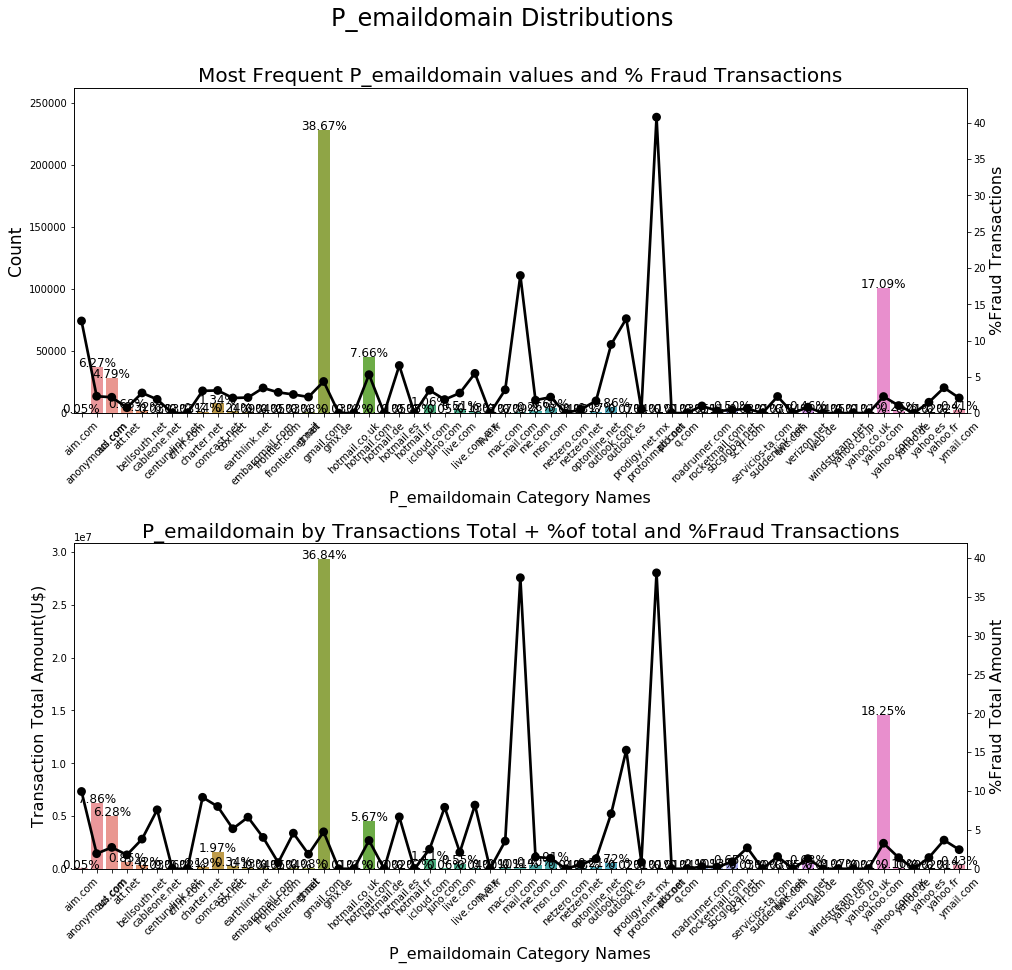

In [16]:
total = len(train)
total_amt = train['TransactionAmt'].sum()
TARGET = 'isFraud'

train['TransactionAmt'] = train['TransactionAmt'].astype('float64')

tmp = pd.crosstab(train['P_emaildomain'], train['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp['count'] = train['P_emaildomain'].value_counts()[tmp['P_emaildomain']].values
tmp['perc'] = train['P_emaildomain'].value_counts()[tmp['P_emaildomain']].values / total * 100
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
print(tmp.sort_values(by='Fraud', ascending=False).head(7))

#df_train['P_emaildomain'] = (df_train['P_emaildomain'] == 'mail.com')
ploting_cnt_amt(train, 'P_emaildomain')

In [19]:
train[train['P_emaildomain'] == 'xmail.com']

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
